# Self-Driving Car Engineer Nanodegree


## Vehicle Detection Project

I have setup a ipython notebook to work on Vehicle Detection Project


## Import Packages

In [7]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
import os
import random
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline

## Get Images

For obtaining images i referred to the example below.
Referred to example from https://www.pythoncentral.io/how-to-traverse-a-directory-tree-in-python-guide-to-os-walk/

In [8]:
def get_images(path):
    images = []
    for dirs, subdir, files in os.walk(path):
        print(dirs, subdir)
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(dirs, file))
                
    return list(map(lambda img: mpimg.imread(img), images))




In [9]:
vehicle_path = '../car-vehicle-detection/vehicles/vehicles'
vehicles = get_images(vehicle_path)
print(len(vehicles))



../car-vehicle-detection/vehicles/vehicles ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
../car-vehicle-detection/vehicles/vehicles\GTI_Far []
../car-vehicle-detection/vehicles/vehicles\GTI_Left []
../car-vehicle-detection/vehicles/vehicles\GTI_MiddleClose []
../car-vehicle-detection/vehicles/vehicles\GTI_Right []
../car-vehicle-detection/vehicles/vehicles\KITTI_extracted []
8792


In [10]:
non_vehicle_path = '../car-vehicle-detection/non-vehicles/non-vehicles'
non_vehicles = get_images(non_vehicle_path)
print(len(non_vehicles))

../car-vehicle-detection/non-vehicles/non-vehicles ['Extras', 'GTI']
../car-vehicle-detection/non-vehicles/non-vehicles\Extras []
../car-vehicle-detection/non-vehicles/non-vehicles\GTI []
8968


## Output Some Example images

Below is display some vehicle and non vehicle images.

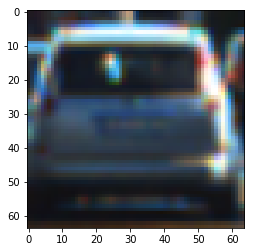

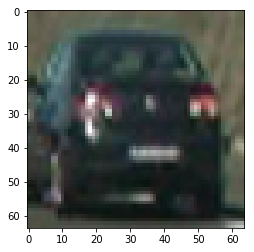

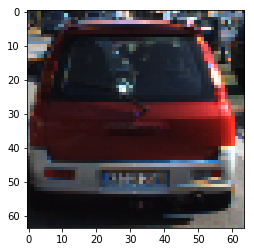

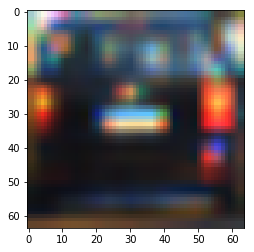

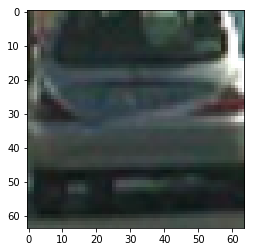

In [11]:
number_of_vehicle_images = 5

for i in range(number_of_vehicle_images):
    index = random.randint(0, len(vehicles))
    image = vehicles[index]
    #plt.figure(figsize=(20,3))
    plt.imshow(image)
    plt.show()

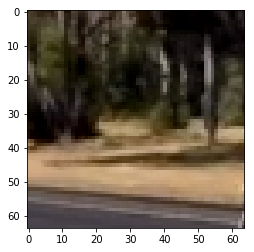

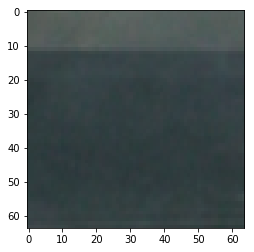

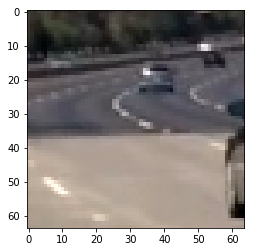

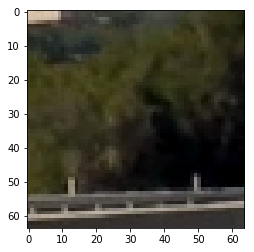

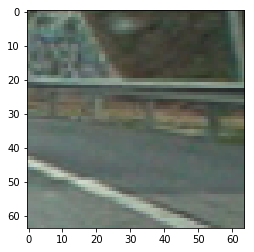

In [12]:
number_of_non_vehicle_images = 5

for i in range(number_of_non_vehicle_images):
    index = random.randint(0, len(non_vehicles))
    image = non_vehicles[index]
    #plt.figure(figsize=(20,3))
    plt.imshow(image)
    plt.show()

In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

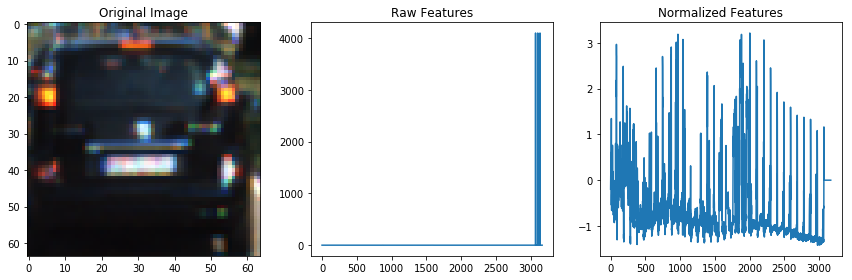

In [17]:
spatial = 32
histbin = 32

car_features = extract_features(vehicles, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(non_vehicles, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(vehicles))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow((vehicles[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [18]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
45.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9127
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
0.17188 Seconds to predict 10 labels with SVC
